# Band Stacking + NDVI

> Making use of H3 global grid indexing when working with rasters. For this example series, we focus on B04 (red), B03 (green), B02 (blue), and B08 (nir).

---
__Last Update:__ 16 JAN 2024 [Mosaic 0.3.14]

## Setup Notes

> Raster processing is memory intensize. Here are some config tips.

* This notebook was run on AWS [r5d.4xlarge](https://www.databricks.com/product/pricing/product-pricing/instance-types) instances (1-10 workers auto-scaling for up to 160 concurrent tasks).
* __Optional:__ Prior to launching, the following can be added to the cluster spark configs, adapted from this databricks [blog](https://www.databricks.com/blog/2015/05/28/tuning-java-garbage-collection-for-spark-applications.html) and these JVM tuning [docs](https://docs.oracle.com/cd/E40972_01/doc.70/e40973/cnf_jvmgc.htm#autoId2): `spark.executor.extraJavaOptions -XX:+UseG1GC -XX:+PrintFlagsFinal -XX:InitiatingHeapOccupancyPercent=35 -XX:G1HeapRegionSize=32M -XX:ParallelGCThreads=16 -XX:ConcGCThreads=4`. _This optimization is not required for this example._

## Imports + Config

In [0]:
%pip install --quiet 'databricks-mosaic<0.4,>=0.3'
%pip install --quiet databricks-mosaic rasterio==1.3.5 gdal==3.4.3 pystac pystac_client planetary_computer tenacity rich

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# -- configure AQE for more compute heavy operations
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", False)
spark.conf.set("spark.sql.shuffle.partitions", 512)

# -- import databricks + delta + spark functions
from delta.tables import *
from pyspark.databricks.sql import functions as dbf
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *
from pyspark.sql.window import Window

# -- setup mosaic
import mosaic as mos

mos.enable_mosaic(spark, dbutils)
mos.enable_gdal(spark)

# -- other imports
from datetime import datetime
from io import BytesIO
from matplotlib import pyplot
from rasterio.io import MemoryFile

import library
import os
import pathlib
import planetary_computer
import pystac_client
import rasterio
import requests
import warnings

warnings.simplefilter("ignore")

GDAL enabled.

GDAL 3.4.3, released 2022/04/22




In [0]:
mos.__version__

Out[2]: '0.3.14'

In [0]:
%reload_ext autoreload
%autoreload 2
%reload_ext library

### Databricks Catalog + Schema

> This is for reading and writing out table(s). __Note: these should already exists after running notebook 01.__

In [0]:
# adjust to match your catalog + schema
catalog_name = "geospatial_docs"
db_name = "eo_alaska"

sql(f"""USE CATALOG {catalog_name}""")
sql(f"""USE DATABASE {db_name}""")

Out[4]: DataFrame[]

## Data load

_We are focusing on the gridded tables for band stacking and NDVI._

In [0]:
%sql show tables

database,tableName,isTemporary
eo_alaska,band_b02,false
eo_alaska,band_b02_h3,false
eo_alaska,band_b02_h3_clip,false
eo_alaska,band_b02_h3_merge,false
eo_alaska,band_b02_tile,false
eo_alaska,band_b03,false
eo_alaska,band_b03_h3,false
eo_alaska,band_b03_tile,false
eo_alaska,band_b04,false
eo_alaska,band_b04_h3,false


In [0]:
df_b02_h3 = spark.read.table("band_b02_h3")
df_b03_h3 = spark.read.table("band_b03_h3")
df_b04_h3 = spark.read.table("band_b04_h3")
df_b08_h3 = spark.read.table("band_b08_h3")

## Band Stacking

> We are going to merge bands into rasters from the same h3 cells.

_[1] Consolidate to 1 tile per H3 cell per day with `rst_merge_agg` aggregate function._ __Note: the following shows the multiple tiles in some cells.__

In [0]:
display(
  df_b02_h3.groupBy("index_id", "date", "band_name")
    .count()
  .orderBy(F.desc("count"))
  .limit(25)
)

index_id,date,band_name,count
608215612686073855,2021-06-01,B02,8
608222632508129279,2021-06-01,B02,8
608598779938996223,2021-06-01,B02,8
608598759638564863,2021-06-01,B02,8
608215610354040831,2021-06-01,B02,8
608215612618964991,2021-06-01,B02,8
608215613189390335,2021-06-01,B02,8
608598759420461055,2021-06-01,B02,8
608598778412269567,2021-06-01,B02,8
608598779989327871,2021-06-01,B02,8


In [0]:
df_b02_resolved = df_b02_h3.groupBy("index_id", "date", "band_name")\
  .agg(mos.rst_merge_agg("tile").alias("tile"))

df_b03_resolved = df_b03_h3.groupBy("index_id", "date", "band_name")\
  .agg(mos.rst_merge_agg("tile").alias("tile"))

df_b04_resolved = df_b04_h3.groupBy("index_id", "date", "band_name")\
  .agg(mos.rst_merge_agg("tile").alias("tile"))

df_b08_resolved = df_b08_h3.groupBy("index_id", "date", "band_name")\
  .agg(mos.rst_merge_agg("tile").alias("tile"))

_Here is example of the resolved output._

In [0]:
print(f"band 02 resolved count? {df_b02_resolved.count():,}")
df_b02_resolved.limit(10).display()

band 02 resolved count? 432,865


index_id,date,band_name,tile
608031197695574015,2021-06-01,B02,"List(608031197695574015, SUkqAAgAAAASAAABAwABAAAAXAEAAAEBAwABAAAAgAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2B_MSIL2A_20210601T213529_R086_T07WEU_20210602T053312_20210601-213529.tif, GTiff)"
608197062957203455,2021-06-01,B02,"List(608197062957203455, SUkqAAgAAAASAAABAwABAAAAcAEAAAEBAwABAAAAigAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WDS_20210602T080222_20210601-222531.tif, GTiff)"
608197067017289727,2021-06-01,B02,"List(608197067017289727, SUkqAAgAAAASAAABAwABAAAAbwEAAAEBAwABAAAAjAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WDS_20210602T080222_20210601-222531.tif, GTiff)"
608197099514757119,2021-06-01,B02,"List(608197099514757119, SUkqAAgAAAASAAABAwABAAAAdAEAAAEBAwABAAAAjQAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAdAAAAWgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAdAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WES_20210602T064730_20210601-222531.tif, GTiff)"
608197099716083711,2021-06-01,B02,"List(608197099716083711, SUkqAAgAAAASAAABAwABAAAAbwEAAAEBAwABAAAAiwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAcAAAAVgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAcAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WES_20210602T064730_20210601-222531.tif, GTiff)"
608197102115225599,2021-06-01,B02,"List(608197102115225599, SUkqAAgAAAASAAABAwABAAAAcQEAAAEBAwABAAAAjQAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAdAAAAWgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAdAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T04WES_20210602T064730_20210601-222531.tif, GTiff)"
608197198114455551,2021-06-01,B02,"List(608197198114455551, SUkqAAgAAAASAAABAwABAAAAggEAAAEBAwABAAAAkQAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAdAAAAWgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAdAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T03WXM_20210602T072927_20210601-222531.tif, GTiff)"
608197199339192319,2021-06-01,B02,"List(608197199339192319, SUkqAAgAAAASAAABAwABAAAAggEAAAEBAwABAAAAkQAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAdAAAAWgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAdAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T03WXM_20210602T072927_20210601-222531.tif, GTiff)"
608197219387965439,2021-06-01,B02,"List(608197219387965439, SUkqAAgAAAASAAABAwABAAAAfgEAAAEBAwABAAAAkgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAeAAAAXgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAeAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T03VXL_20210602T080313_20210601-222531.tif, GTiff)"
608197224303689727,2021-06-01,B02,"List(608197224303689727, SUkqAAgAAAASAAABAwABAAAAfwEAAAEBAwABAAAAkQAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAdAAAAWgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAdAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T03VXL_20210602T080313_20210601-222531.tif,

_[2] Band stack per H3 tile; in this case, red, green, blue, and nir._

_[a] Here is a brief example of using union and window to stack by (ordered) band_name._

In [0]:
stack_win = Window.partitionBy("index_id","date").orderBy('band_name')

display (
  df_b02_resolved
    .filter("index_id = 608197214103142399")
  .union(
    df_b03_resolved
      .filter("index_id = 608197214103142399")
  )
  .union(
    df_b04_resolved
      .filter("index_id = 608197214103142399")
  )
  .union(
    df_b08_resolved
      .filter("index_id = 608197214103142399")
  )
  .select(
    "date",
    F
      .collect_list("tile")
        .over(stack_win)
      .alias("tiles")
  )
  .filter("array_size(tiles) = 4")
  .withColumn("tile", mos.rst_frombands("tiles"))
  .withColumn("tile", mos.rst_initnodata("tile"))
  .withColumn("memsize", mos.rst_memsize("tile"))
  .withColumn("num_bands", mos.rst_numbands("tile"))
)

date,tiles,tile,memsize,num_bands
2021-06-01,"List(List(608197214103142399, SUkqAAgAAAASAAABAwABAAAAfAEAAAEBAwABAAAAkgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAeAAAAXgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAeAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T03VXL_20210602T080313_20210601-222531.tif, GTiff), List(608197214103142399, SUkqAAgAAAASAAABAwABAAAAfAEAAAEBAwABAAAAkgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAeAAAAXgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAeAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B03/B03_S2A_MSIL2A_20210601T222531_R015_T03VXL_20210602T080313_20210601-222531.tif, GTiff), List(608197214103142399, SUkqAAgAAAASAAABAwABAAAAfAEAAAEBAwABAAAAkgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAeAAAAXgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAeAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B04/B04_S2A_MSIL2A_20210601T222531_R015_T03VXL_20210602T080313_20210601-222531.tif, GTiff), List(608197214103142399, SUkqAAgAAAASAAABAwABAAAAfAEAAAEBAwABAAAAkgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAeAAAAXgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAeAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B08/B08_S2A_MSIL2A_20210601T222531_R015_T03VXL_20210602T080313_20210601-222531.tif, GTiff))","List(608197214103142399, SUkqAAgAAAASAAABAwABAAAAfAEAAAEBAwABAAAAkgAAAAIBAwAEAAAA5gAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBABJAAAAgAEAABUBAwABAAAABAAAABYBAwABAAAAAgAAABcBAwBJAAAA7gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T03VXL_20210602T080313_20210601-222531.tif, GTiff)",444696,4


_[b] Here is the main example, where we join new columns for each band to generate a stacked raster (in the order we choose)._

> Hint: joins default to inner, if you want something different add arg 'how'.

In [0]:
stack_tbl_name = "band_stack"
# sql(f"""drop table if exists {stack_tbl_name}""") # <- uncomment to drop
if not spark.catalog.tableExists(stack_tbl_name):
  try:
    repartition_factor = 100 # <- num tiles per task
    orig_repart_num = spark.conf.get("spark.sql.shuffle.partitions")
    spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", False)
    repart_num = round(df_b02_resolved.count() / repartition_factor)
    spark.conf.set("spark.sql.shuffle.partitions", repart_num)
    print(f"\t...shuffle partitions to {repart_num} for this operation.")
    (
      df_b02_resolved
        .drop("band_name")
        .repartition(repart_num, "tile")
        .withColumnRenamed("tile", "b02")
        .join(
          df_b03_resolved
            .drop("band_name")
            .repartition(repart_num, "tile")
            .withColumnRenamed("tile", "b03"),
          on = ["index_id", "date"]
        )
        .join(
          df_b04_resolved
            .drop("band_name")
            .repartition(repart_num, "tile")
            .withColumnRenamed("tile", "b04"),
          on = ["index_id", "date"]
        )
        .join(
          df_b08_resolved
            .drop("band_name")
            .repartition(repart_num, "tile")
            .withColumnRenamed("tile", "b08"),
          on = ["index_id", "date"]
        )
        .withColumn("tile", mos.rst_frombands(F.array("b04","b03","b02","b08"))) 
        .withColumn("tile", mos.rst_initnodata("tile"))
        .withColumn("memsize", mos.rst_memsize("tile"))
        .withColumn("num_bands", mos.rst_numbands("tile"))
        #.drop("b04", "b03", "b02", "b08") <- keep for now
      .write
      .saveAsTable(stack_tbl_name)
    )
  finally:
    # print(f"...setting shuffle partitions back to {orig_repart_num}")
    spark.conf.set("spark.sql.shuffle.partitions", orig_repart_num)
  
sql(f"""OPTIMIZE {stack_tbl_name} ZORDER BY (index_id)""")
stacked_df = spark.table(stack_tbl_name)
print(f"count? {stacked_df.count():,}")
stacked_df.limit(1).show(vertical=True) # <- show + limiting for ipynb only

count? 432,864
-RECORD 0-------------------------
 index_id  | 608031185615978495   
 date      | 2021-06-01           
 b02       | {6080311856159784... 
 b03       | {6080311856159784... 
 b04       | {6080311856159784... 
 b08       | {6080311856159784... 
 tile      | {6080311856159784... 
 memsize   | 346540               
 num_bands | 4                    



In [0]:
import json
json.loads(stacked_df.filter("index_id = 608197214103142399").select(mos.rst_summary("tile")).first()[0])

Out[12]: {'description': '/local_disk0/tmp/mosaic7830623134705399542/raster_f881ca6f_194a_4dcf_becf_738c5d61e9a3.tif',
 'driverShortName': 'GTiff',
 'driverLongName': 'GeoTIFF',
 'files': ['/local_disk0/tmp/mosaic7830623134705399542/raster_f881ca6f_194a_4dcf_becf_738c5d61e9a3.tif'],
 'size': [380, 146],
 'coordinateSystem': {'wkt': 'GEOGCRS["WGS 84",\n    DATUM["World Geodetic System 1984",\n        ELLIPSOID["WGS 84",6378137,298.257223563,\n            LENGTHUNIT["metre",1]]],\n    PRIMEM["Greenwich",0,\n        ANGLEUNIT["degree",0.0174532925199433]],\n    CS[ellipsoidal,2],\n        AXIS["geodetic latitude (Lat)",north,\n            ORDER[1],\n            ANGLEUNIT["degree",0.0174532925199433]],\n        AXIS["geodetic longitude (Lon)",east,\n            ORDER[2],\n            ANGLEUNIT["degree",0.0174532925199433]],\n    ID["EPSG",4326]]',
  'dataAxisToSRSAxisMapping': [2, 1]},
 'geoTransform': [-162.25046779664547,
  0.0001513953444553,
  0.0,
  63.6490673109844,
  0.0,
  -0.00015

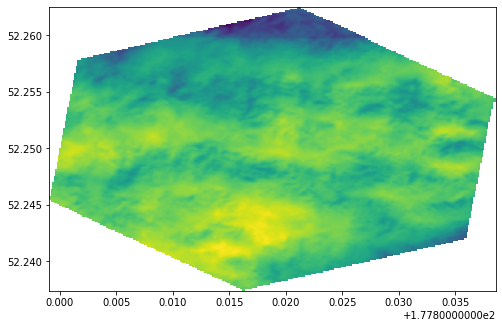

In [0]:
library.plot_raster(stacked_df.select("tile", "memsize").filter("memsize > 400000").first()["tile"]["raster"])

## NDVI Calculation

> Now that we have our band-stacked tiles, using mosaic's `rst_ndvi` we can calculate [NDVI](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/) from the red and nir bands. _Note: we could also use mosaic's more flexible `rst_mapalgebra` which wraps [gdal_calc](https://gdal.org/programs/gdal_calc.html)._

__NDVI over full data can take multiple hours, recommend filtering as shown below (`filter(col("item_id").contains("_R014_"))`) will shorten the processing time.__

In [0]:
ndvi_tbl_name = "ndvi_calc"
# sql(f"""drop table if exists {ndvi_tbl_name}""") # <- uncomment to drop
if not spark.catalog.tableExists(ndvi_tbl_name):
  repartition_factor = 100
  (
    stacked_df
      #.filter(col("item_id").contains("_R014_"))  # <- uncomment to filter 
      .repartition(round(stacked_df.count() / repartition_factor), "tile")
      .withColumn("ndvi", mos.rst_ndvi("tile", F.lit(1), F.lit(4))) # 01 = red, 04 = nir
    .write
    .saveAsTable(ndvi_tbl_name)
  )
sql(f"""OPTIMIZE {ndvi_tbl_name} ZORDER BY (index_id)""")
ndvi_df = spark.table(ndvi_tbl_name)
print(f"count? {ndvi_df.count():,}")
ndvi_df.limit(1).show(vertical=True) # <- show + limiting for ipynb only

count? 432,864
-RECORD 0-------------------------
 index_id  | 608031187847348223   
 date      | 2021-06-01           
 b02       | {6080311878473482... 
 b03       | {6080311878473482... 
 b04       | {6080311878473482... 
 b08       | {6080311878473482... 
 tile      | {6080311878473482... 
 memsize   | 355106               
 num_bands | 4                    
 ndvi      | {6080311878473482... 



In [0]:
to_plot = ndvi_df.limit(50).collect()

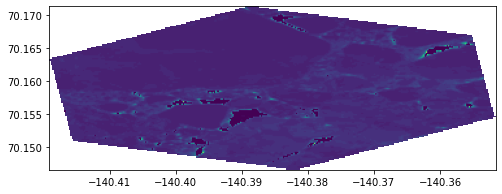

In [0]:
library.plot_raster(to_plot[4]["ndvi"]["raster"])